# Task

Select the months between May-September, perform PCA on these months to get the best linear combination of warm months and save the new tiff files.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import os
import torch
from sklearn.decomposition import PCA
import logging

from joblib import Parallel, delayed

from skimage import io

from bioMass.dataloader import train_df, read_yearly_tiffs

# logfile = '/home/ubuntu/Thesis/backup_data/bioMass_data/train_PCA_warm/log_test.txt'

# logging.basicConfig(filename=logfile, level=logging.DEBUG, format="%(asctime)s %(message)s", filemode="w")


def plot_months(data, months_list, band_no, cmap='viridis'):
    
    fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(10, 8))
    list(map(lambda axi: axi.set_axis_off(), ax.ravel()))
    plt.tight_layout()


    for month, month_data in zip(months_list, data):
        col = month%4
        row = month//4
        ax[row][col].imshow(month_data[band_no], cmap=cmap)
        
    plt.show()
    
    return

%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# def get_warm_data(data, months_list):
#     warm_months = [0, 8, 9, 10, 11] # Sep, May, June, July, August
    
#     data_warm = []
#     months_list_warm = []
#     for m, d in zip(months_list, data):
#         if m in warm_months:
#             # compute number of zeros and only append if more than 60%
#             pct_zeros = (d==0).sum()/len(d.flatten())
#             if pct_zeros>0.6:
#                 data_warm.append(d)
#                 months_list_warm.append(m)
            
    
#     return data_warm, months_list_warm  

def get_warm_data(data, months_list):
    warm_months = [0, 8, 9, 10, 11] # Sep, May, June, July, August
    
    data_warm = []
    months_list_warm = []
    for m, d in zip(months_list, data):
        if m in warm_months:
            data_warm.append(d)
            months_list_warm.append(m)

    return data_warm, months_list_warm 

def PCA_by_band(data, band_no, n_components=1):
    single_band_year = np.array(data)[:, band_no, :, :]
    single_band_year = single_band_year.reshape((len(single_band_year), 256*256)).T

    pct_zeros = (single_band_year==0).sum()/len(single_band_year.flatten())
    
    if pct_zeros>0.5:
        print('Band No. %i. Too many zeros!' %band_no)

    if single_band_year.std()>0:
        single_band_year = (single_band_year - single_band_year.mean()) / single_band_year.std()

        pca = PCA(n_components=n_components)

        reduced_single_band = pca.fit_transform(single_band_year).flatten().reshape(256, 256)

        print('Band No. %i, Explained variance ratio: %.03f' %(band_no, pca.explained_variance_ratio_[0]))

    else:
        reduced_single_band = single_band_year.T[0].flatten().reshape(256, 256)
        print('Variance was zero!!!')

    return reduced_single_band   

In [17]:
def compute_PCA_data(chipid, satellite):
    output_folder = '/home/ubuntu/Thesis/backup_data/bioMass_data/train_PCA_warm/'
    output_filename = '%s_%s.tif' %(chipid, satellite)
    output_filename = os.path.join(output_folder, output_filename)
    
    if satellite=='S1':
        total_bands = 4
    elif satellite=='S2':
        total_bands = 11
    
    # if not os.path.exists(output_filename):
    if True:

        data, months_list, agbm = read_yearly_tiffs(chipid, satellite)  
        data, months_list = get_warm_data(data, months_list)

        print('Chip ID: %s, Satellite: %s, # Warm months: %i' %(chipid, satellite, len(months_list)))

        if len(months_list)<2:
            logging.info('Not enough data to compute PCA for this Chip ID!!!!')
        
        else:
            reduced_data = [PCA_by_band(data, band_no) for band_no in range(0, total_bands)]

            out_data = np.array(reduced_data)
            # io.imsave('test.tif', out_data, plugin='tifffile')
            # tifffile.imsave(output_filename, out_data)
            return out_data
    else:
        pass
    
    return

In [18]:
for satellite in ['S2', 'S1']: 
    for chipid in ['192eb2e0', 'd961dfda']:
        compute_PCA_data(chipid=chipid, satellite=satellite)
        break

Chip ID: 192eb2e0, Satellite: S2, # Warm months: 5
Band No. 0. Too many zeros!
Band No. 0, Explained variance ratio: 0.974
Band No. 1. Too many zeros!
Band No. 1, Explained variance ratio: 0.943
Band No. 2. Too many zeros!
Band No. 2, Explained variance ratio: 0.961
Band No. 3. Too many zeros!
Band No. 3, Explained variance ratio: 0.870
Band No. 4. Too many zeros!
Band No. 4, Explained variance ratio: 0.620
Band No. 5. Too many zeros!
Band No. 5, Explained variance ratio: 0.584
Band No. 6. Too many zeros!
Band No. 6, Explained variance ratio: 0.605
Band No. 7. Too many zeros!
Band No. 7, Explained variance ratio: 0.568
Band No. 8. Too many zeros!
Band No. 8, Explained variance ratio: 0.743
Band No. 9. Too many zeros!
Band No. 9, Explained variance ratio: 0.882
Band No. 10. Too many zeros!
Band No. 10, Explained variance ratio: 0.994
Chip ID: 192eb2e0, Satellite: S1, # Warm months: 5
Band No. 0, Explained variance ratio: 0.926
Band No. 1, Explained variance ratio: 0.941
Band No. 2, Expl

# Number of chips with zero values

After running the script `get_PCA_tiffs.py`, many images have only zero values. I want to see which files and what is their proportion.

In [5]:
from glob import glob
from tifffile import tifffile

pca_folder = '/home/ubuntu/Thesis/backup_data/bioMass_data/train_PCA_warm/'

files = glob(pca_folder+'*')

filenames = [x.replace(pca_folder, '') for x in files]

S1_chips = [x for x in filenames if 'S1' in x]
S2_chips = [x for x in filenames if 'S2' in x]

In [6]:
files = glob(pca_folder+'*S2*')
len(files)

8689

In [7]:
def get_zero_files(file):
    
    img = tifffile.imread(f)
    img = np.float32(img)
    
    zeros_per_band = [(x==0).sum() for x in img]
    zeros_per_band = np.array(zeros_per_band)/(256*256) # size of our images is 256x256
    
    if np.array(zeros_per_band).sum()!=0:
        zero_files.append(f)
        return f
    
    else:
        return -1

In [113]:
zero_files = []
all_zero_freqs = []

for f in tqdm(files):
    img = tifffile.imread(f)
    img = np.float32(img)
    
    zeros_per_band = [(x==0).sum() for x in img]
    zeros_per_band = np.array(zeros_per_band)/(256*256) # size of our images is 256x256
    all_zero_freqs.append(zeros_per_band)
    
    if np.array(zeros_per_band).sum()!=0:
        zero_files.append(f)

100%|███████████████████████████████████| 8689/8689 [28:05<00:00,  5.15it/s]


In [114]:
len(zero_files)

20

In [115]:
zero_files

['/home/ubuntu/Thesis/backup_data/bioMass_data/train_PCA_warm/d961dfda_S2.tif',
 '/home/ubuntu/Thesis/backup_data/bioMass_data/train_PCA_warm/6bb8df22_S2.tif',
 '/home/ubuntu/Thesis/backup_data/bioMass_data/train_PCA_warm/ed84be75_S2.tif',
 '/home/ubuntu/Thesis/backup_data/bioMass_data/train_PCA_warm/38c1ff72_S2.tif',
 '/home/ubuntu/Thesis/backup_data/bioMass_data/train_PCA_warm/e253ed6c_S2.tif',
 '/home/ubuntu/Thesis/backup_data/bioMass_data/train_PCA_warm/eb51fd4d_S2.tif',
 '/home/ubuntu/Thesis/backup_data/bioMass_data/train_PCA_warm/38b35fbf_S2.tif',
 '/home/ubuntu/Thesis/backup_data/bioMass_data/train_PCA_warm/175c2e5e_S2.tif',
 '/home/ubuntu/Thesis/backup_data/bioMass_data/train_PCA_warm/460a7643_S2.tif',
 '/home/ubuntu/Thesis/backup_data/bioMass_data/train_PCA_warm/61d6c948_S2.tif',
 '/home/ubuntu/Thesis/backup_data/bioMass_data/train_PCA_warm/fe36ba3f_S2.tif',
 '/home/ubuntu/Thesis/backup_data/bioMass_data/train_PCA_warm/fb99942c_S2.tif',
 '/home/ubuntu/Thesis/backup_data/bioMas

In [120]:
for f in zero_files:
    img = tifffile.imread(f)
    zeros_per_band = [(x==0).sum() for x in img]
    zeros_per_band = np.array(zeros_per_band)/(256*256) 
    print(zeros_per_band)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]


In [28]:
# file = '/home/ubuntu/Thesis/backup_data/bioMass_data/train_PCA_warm/192eb2e0_S2.tif'
file = '/home/ubuntu/Thesis/backup_data/bioMass_data/train_PCA_warm/1b7a76f8_S2.tif'

img = tifffile.imread(file)
zeros_per_band = [(x==x.min()).sum() for x in img]
zeros_per_band = np.array(zeros_per_band)/(256*256) 
print(zeros_per_band)

[1.52587891e-05 7.57705688e-01 1.52587891e-05 7.62924194e-01
 1.52587891e-05 1.52587891e-05 7.57705688e-01 1.52587891e-05
 1.52587891e-05 7.62924194e-01 1.52587891e-05]


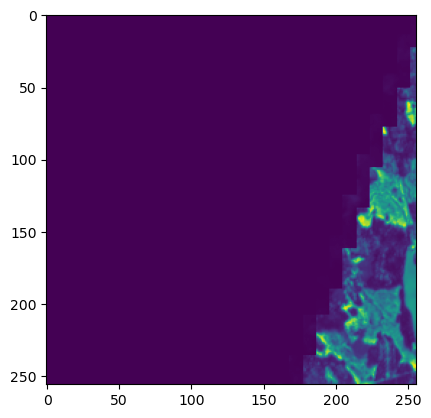

In [32]:
plt.imshow(img[2])

In [21]:
img[0].var()

3.5386340175903728

(array([5.8307e+04, 2.5200e+03, 1.0100e+03, 9.0900e+02, 1.1460e+03,
        8.7100e+02, 3.8200e+02, 2.1200e+02, 1.2900e+02, 5.0000e+01]),
 array([-0.60592953,  0.88771424,  2.38135801,  3.87500178,  5.36864555,
         6.86228932,  8.35593309,  9.84957687, 11.34322064, 12.83686441,
        14.33050818]),
 <BarContainer object of 10 artists>)

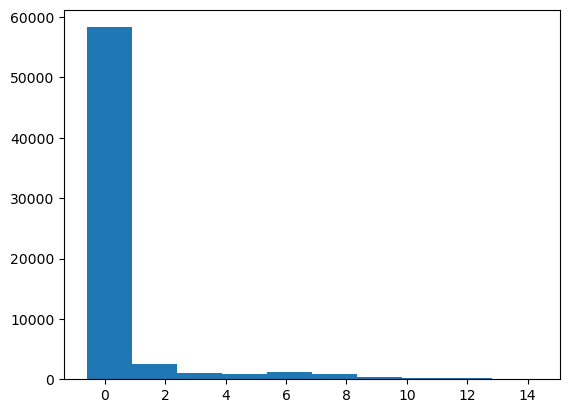

In [33]:
plt.hist(img[2].flatten())